In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

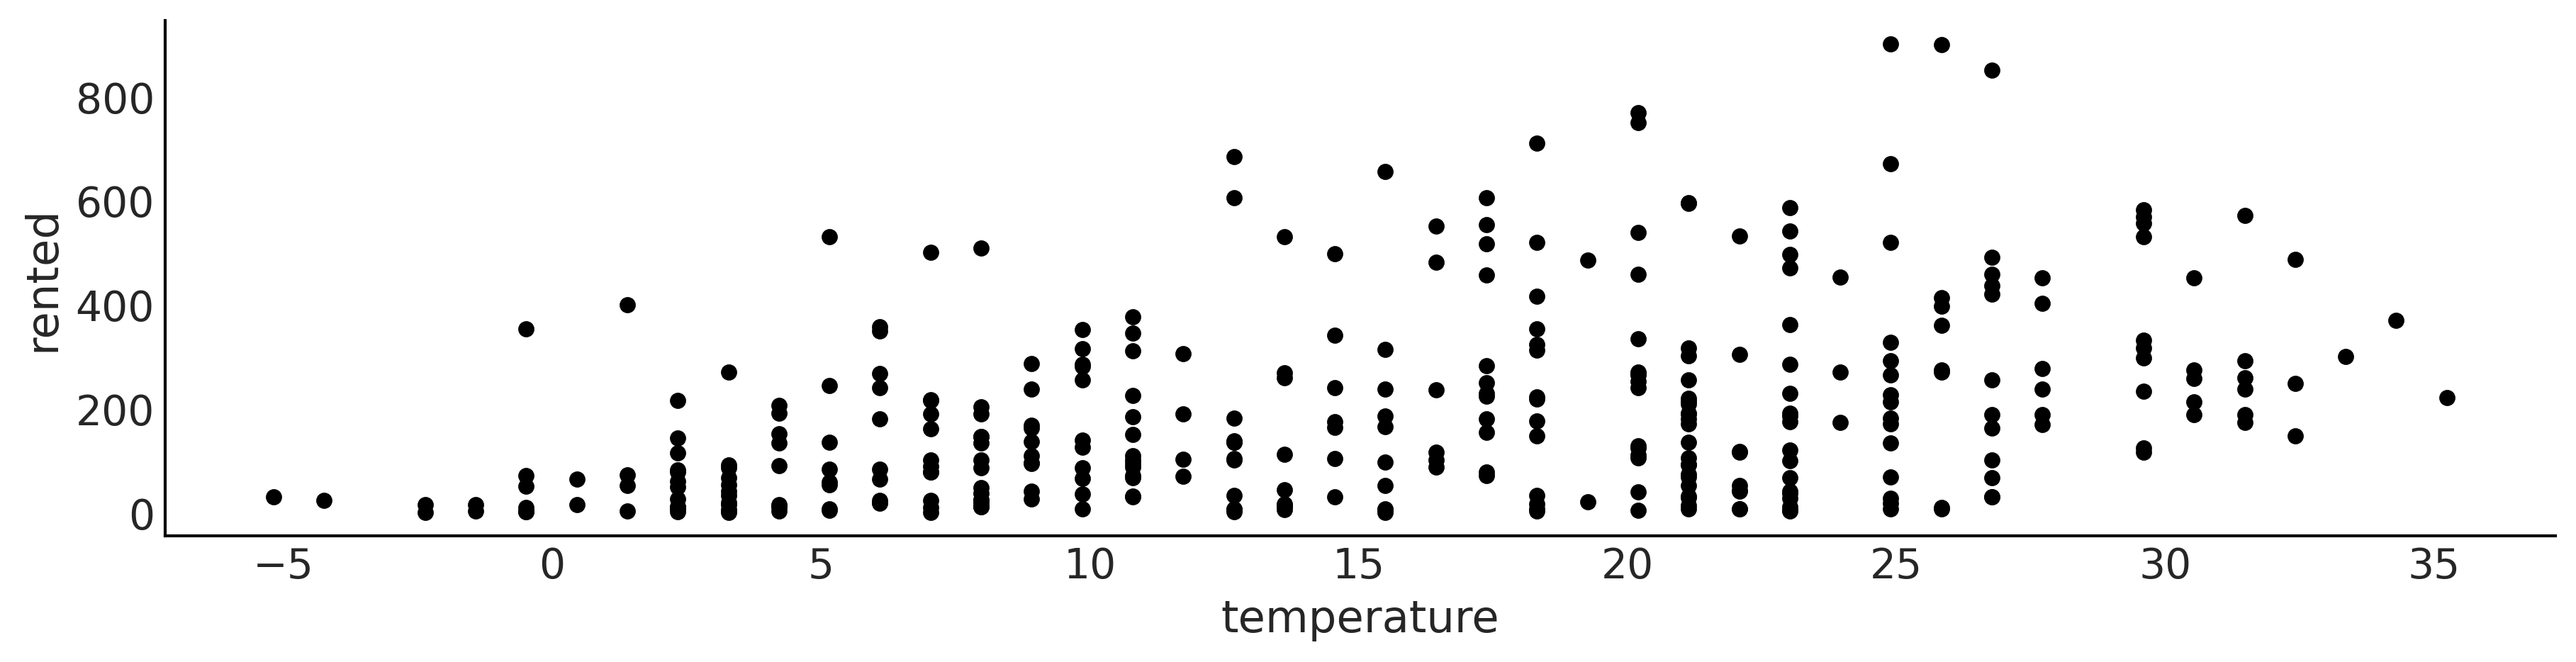

In [3]:
bikes = pd.read_csv("data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [4]:
with pm.Model() as model_lb:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * bikes.temperature)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

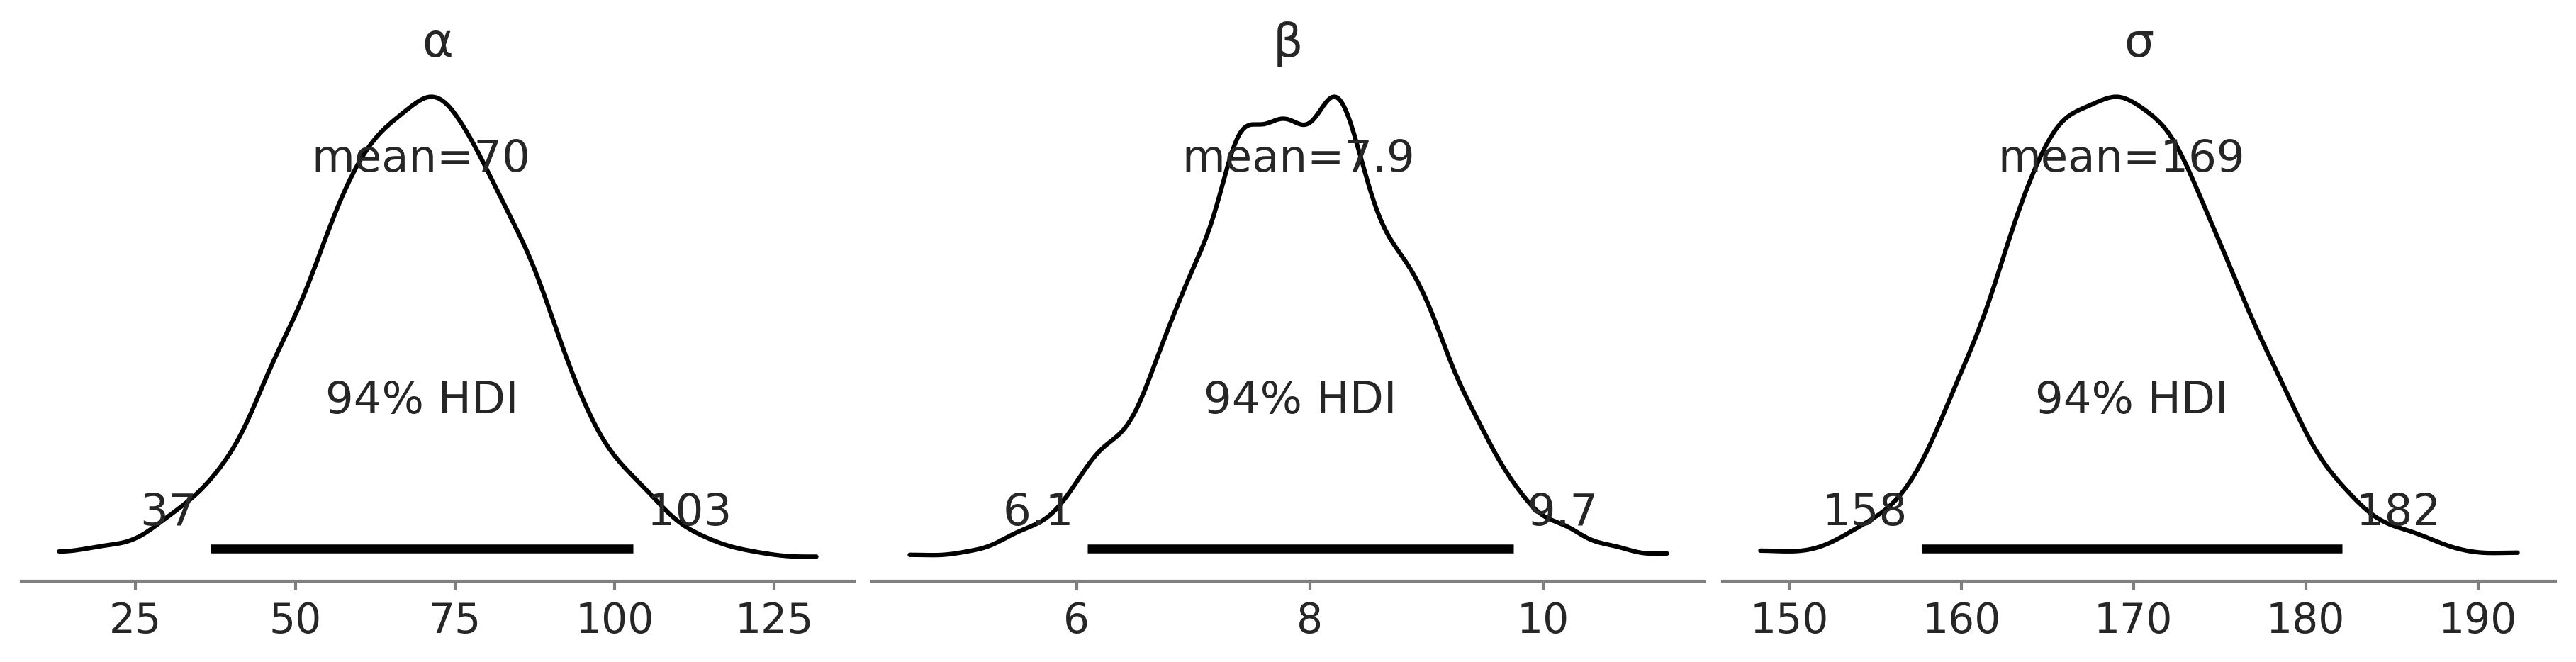

In [5]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

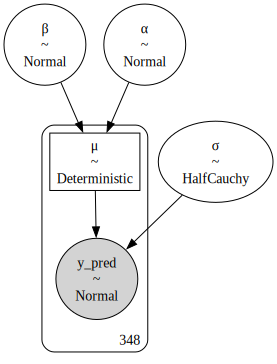

In [6]:
pm.model_to_graphviz(model_lb)

In [10]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims="plot_id"
)

In [11]:
x_plot

<xarray.DataArray (plot_id: 50)>
array([-5.18      , -4.35510204, -3.53020408, -2.70530612, -1.88040816,
       -1.0555102 , -0.23061224,  0.59428571,  1.41918367,  2.24408163,
        3.06897959,  3.89387755,  4.71877551,  5.54367347,  6.36857143,
        7.19346939,  8.01836735,  8.84326531,  9.66816327, 10.49306122,
       11.31795918, 12.14285714, 12.9677551 , 13.79265306, 14.61755102,
       15.44244898, 16.26734694, 17.0922449 , 17.91714286, 18.74204082,
       19.56693878, 20.39183673, 21.21673469, 22.04163265, 22.86653061,
       23.69142857, 24.51632653, 25.34122449, 26.16612245, 26.99102041,
       27.81591837, 28.64081633, 29.46571429, 30.29061224, 31.1155102 ,
       31.94040816, 32.76530612, 33.59020408, 34.41510204, 35.24      ])
Dimensions without coordinates: plot_id

In [12]:
posterior

<xarray.Dataset>
Dimensions:  (sample: 50, μ_dim_0: 348)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 1 3 1 1 2 0 2 3 1 0 3 ... 1 2 0 3 1 2 3 1 2 0 0 1
  * draw     (sample) int64 894 191 602 997 862 919 ... 238 164 236 376 341 10
Data variables:
    α        (sample) float64 46.75 70.94 62.44 92.63 ... 54.91 74.87 45.07
    β        (sample) float64 9.587 7.773 7.355 6.528 ... 7.913 8.237 9.772
    σ        (sample) float64 163.0 167.3 174.0 164.8 ... 181.0 172.1 163.4
    μ        (μ_dim_0, sample) float64 78.19 96.44 86.57 ... 118.1 140.6 123.0
Attributes:
    created_at:                 2024-03-15T03:49:50.790426
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.4403181076049805
    tuning_steps:               1000

In [13]:
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

In [14]:
mean_line

<xarray.DataArray (plot_id: 50)>
array([ 21.34210574,  28.20051214,  35.05891854,  41.91732494,
        48.77573134,  55.63413774,  62.49254414,  69.35095054,
        76.20935694,  83.06776334,  89.92616974,  96.78457614,
       103.64298254, 110.50138894, 117.35979534, 124.21820174,
       131.07660814, 137.93501455, 144.79342095, 151.65182735,
       158.51023375, 165.36864015, 172.22704655, 179.08545295,
       185.94385935, 192.80226575, 199.66067215, 206.51907855,
       213.37748495, 220.23589135, 227.09429775, 233.95270415,
       240.81111055, 247.66951695, 254.52792335, 261.38632975,
       268.24473615, 275.10314255, 281.96154895, 288.81995535,
       295.67836175, 302.53676815, 309.39517456, 316.25358096,
       323.11198736, 329.97039376, 336.82880016, 343.68720656,
       350.54561296, 357.40401936])
Dimensions without coordinates: plot_id